### Extration Feature with Gray Level Co-occurrence Matrix (GLCM)
@created_at: 17 Sept 2023
<hr/>

### Introduction

<p style="line-height:30px; text-align: justify; padding: 40px;">Bawang merah merupakan tanaman umbi yang banyak dikonsumsi masyarakat Indonesia, baik sebagai bumbu masakan maupun obat herbal. Dalam proses pembudidayaan bawang merah terdapat hama dan juga penyakit yang menyerang dikarenakan bawang merah rentan terhadap infeksi bakteri dan jamur. <br/> <br/>
Skala intensitas kerusakan daun dapat dilihat dengan tanda-tanda yang tampak yaitu daun yang tidak berwarna hijau karena berubah warna dan layu. Melalui pengamatan diduga gejala penyakit yang terjadi umumnya klorosis. Perubahan warna ini dapat disebabkan oleh rusaknya klorofil (zat hijau daun) atau akibat kekurangan cahaya matahari atau karena serangan penyakit (Stalin, et al., 2013). 
<br/> <br/>
Gray Level Co-occurrence Matrix (GLCM) adalah analisis tekstur yang sudah banyak digunakan dan hasil yang diperoleh dari matriks co-occurrence lebih baik dari metode diskriminasi tekstur lainnya (Sri Ayu, 2022). Pada penelitian (Nikotesa, et al., 2021) disebutkan bahwa menggunakan ciri warna hue saturation value (HSV) untuk ekstrasi warnanya karena, warna HSV memiliki ruang lingkup yang terdiri dari 3 elemen yaitu hue yang mewakili semua warna, adapun saturation yang mewakili tingkat terhadap dominanasi warna, sedangkan untuk value mewakili tingkat kecerahan sehingga dalam penggunaannya lebih cenderung mendeteksi ketiga elemen tersebut. Tujuan pengubahan warna RGB ke HSV untuk memperoleh campuran warna yang lebih kompleks dengan komposisi tertentu (Nikotesa, et al., 2021).</p>

#### example 

In [1]:
import cv2
import numpy as np

def maskedImg(
    hsv_img: np.ndarray,
    lower: tuple = np.array([5, 50, 50]),
    upper: tuple = np.array([20, 255, 255]),
) -> np.ndarray:
    """
    Mask the image with the given HSV bounds
    :param hsv_img: HSV image
    :param lower: lower HSV bound
    :param upper: upper HSV bound
    :return: masked image
    """
    # Convert image to HSV if it is not
    if len(hsv_img.shape) == 3:
        hsv_img = cv2.cvtColor(hsv_img, cv2.COLOR_BGR2HSV)

    # Mask the image
    mask = cv2.inRange(hsv_img, lower, upper)
    masked_img = cv2.bitwise_and(hsv_img, hsv_img, mask=mask)

    return masked_img

(-0.5, 999.5, 999.5, -0.5)

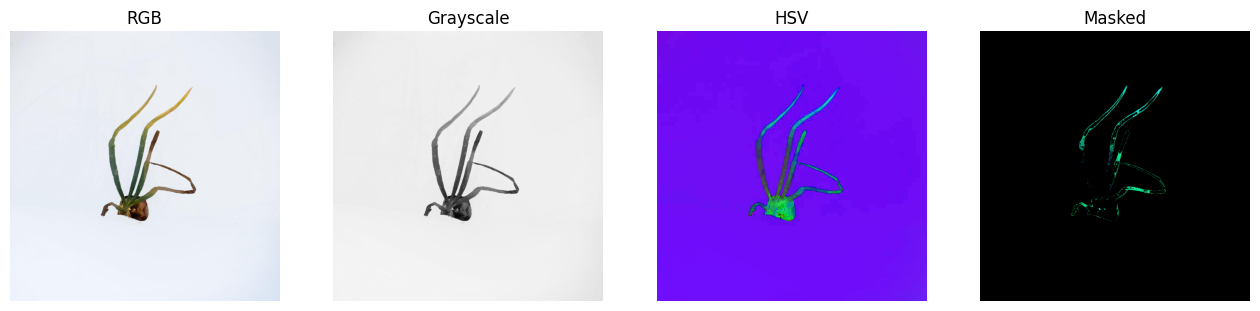

In [2]:
import cv2
from matplotlib import pyplot as plt

img  = cv2.imread('../dataset/Skala4/rusak30.jpg')

rgb_img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
hsv_img  = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
masked_img = maskedImg(hsv_img)

fig, axs = plt.subplots(1, 4, figsize=(16,8))
axs[0].set_title('RGB')
axs[0].imshow(rgb_img)
axs[0].axis('off')
axs[1].set_title('Grayscale')
axs[2].imshow(hsv_img)
axs[1].axis('off')
axs[2].set_title('HSV')
axs[1].imshow(gray_img, cmap='gray')
axs[2].axis('off')
axs[3].set_title('Masked')
axs[3].imshow(masked_img, cmap='gray')
axs[3].axis('off')

#### Let's start!

#### 00. Configuration

In [3]:
IMG_PATH = '../dataset/'    # Path to the dataset
IMG_DIM  = (1000, 1000)     # (width, height)

data         = []
properties   = np.zeros(5)
GLCM_FEATURE = ['contrast', 'homogeneity', 'correlation', 'energy']
featlist     = ['sumValue', 'contrast', 'homogeneity', 'correlation', 'energy', 'hue', 'saturaton', 'value', 'target', 'class']

In [4]:
import os
import math
from skimage.feature import graycomatrix, graycoprops

for idx, folder in enumerate(os.listdir(IMG_PATH)):
    files = os.listdir(os.path.join(IMG_PATH, folder))

    for file in files:
        if file.find(".jpg") > -1:
            image       = cv2.imread(os.path.abspath(os.path.join(IMG_PATH + folder, file)))
            image       = cv2.resize(image, IMG_DIM, interpolation = cv2.INTER_AREA)

            image_hsv    = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            image_masked = maskedImg(image_hsv)

            # Convert matrix to vector
            image_masked_flatten = image_masked.flatten()

            sum = 0
            # for i in range(len(image_masked_flatten)):
            for i in range(3072):
                sum+= image_masked_flatten[i]^2

            sqsum = math.sqrt(sum)

            # Destruct hsv image
            h, s, v = cv2.split(image_hsv)

            # Calculate mean HSV
            h_mean = np.mean(h)
            s_mean = np.mean(s)
            v_mean = np.mean(v)

            # Calculate GLCM
            image_gray   = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            glcm         = (graycomatrix(image_gray, [1], [0], levels=2 ** 8))


            for j in range(0, len(GLCM_FEATURE)):
                properties[j] = (graycoprops(glcm, prop=GLCM_FEATURE[j]))

            features =np.array([
                sqsum,              # Sum of masked image
                properties[0],      # Contrast
                properties[1],      # Homogeneity
                properties[2],      # ASM
                properties[3],      # Energy
                h_mean,             # Mean of H
                s_mean,             # Mean of S
                v_mean,             # Mean of V
                f'{idx}',           # Target
                folder,             # Class
            ])
            data.append(features)

C:\Users\maula\AppData\Local\Temp\ipykernel_24100\4058443204.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  properties[j] = (graycoprops(glcm, prop=GLCM_FEATURE[j]))


In [5]:
print(f'Number of data: {len(data)}')

Number of data: 150


#### Save data to CSV

In [6]:
import pandas as pd

df = pd.DataFrame(data, columns=featlist)
df.to_csv("feature_extraction.csv", index=False)
df.head()

,sumValue,contrast,homogeneity,correlation,energy,hue,saturaton,value,target,class
0,78.38367176906169,16.656466466466465,0.9382952968932857,0.9809193692862531,0.1932293408848133,102.019578,6.076716,239.601118,0,Skala0
1,78.38367176906169,21.848997997997994,0.9162693003700434,0.9902486833594345,0.20461061786814444,107.860592,49.0718,219.021018,0,Skala0
2,78.38367176906169,21.972523523523524,0.9143824130779147,0.9862238529308189,0.16265085533800192,107.70769,42.995309,214.469718,0,Skala0
3,78.38367176906169,53.700931931931926,0.9062718179471196,0.9661759785354006,0.24226702455154506,111.50719,21.193654,218.849183,0,Skala0
4,78.38367176906169,21.086079079079077,0.9050313813085136,0.9755930459617167,0.2039544522774361,108.038949,60.611979,215.771037,0,Skala0
